In [1]:
# import pandas as pd
# from pathlib import Path
# import typing as T
# import av
# import numpy as np

# video_path = "/home/tom/experiments/neon_blink_detection/datasets/test_data/2023-01-27_15-59-54-49a115d5/Neon Sensor Module v1 ps1.mp4"

# container = av.open(video_path)

# frames1 = []
# for idx, pkt in enumerate(container.demux(video=0)):
#     try:
#         frames1.append(pkt.decode()[0].to_ndarray())
#     except:
#         print("End of file")
#     # tmp = container.streams.video[0].decode(pkt)
#     # frame = tmp.to_ndarray()

# frames1 = np.array(frames1)

# container = av.open(video_path)

# frames2 = []
# for frame in container.decode(video=0):
#     y_plane = frame.planes[0]
#     gray_data = np.frombuffer(y_plane, np.uint8)
#     img_np = gray_data.reshape(y_plane.height, y_plane.line_size, 1)
#     img_np = img_np[:, : frame.width]
#     frames2.append(img_np)


In [4]:
import sys

sys.path.append("/cluster/users/tom/git/neon_blink_detection/")
sys.path.append("/cluster/users/tom/git/neon_blink_detection/src")

import pandas as pd
from pathlib import Path
import typing as T
import av
import numpy as np
from src.features_calculator import concatenate_features, calculate_optical_flow
from src.helper import OfParams
from src.utils import resize_images
from functions.utils import random_sample
from training.helper import get_feature_dir_name_new
from src.event_array import Samples
from src.helper import OfParams, PPParams
from training.datasets_loader import (
    Datasets,
    concatenate,
    concatenate_all_samples,
    load_samples,
    save_samples,
)
from functions.classifiers import Classifier, load_predictions, save_predictions
from functions.pipeline import get_classifier_params
from training.helper import ClassifierParams, Results
from training.helper import (
    get_experiment_name_new,
    get_export_dir,
    get_of_params_options,
    get_test_recording_ids,
    get_training_dir,
)

clip_names = np.array(
    [
        "2023-01-27_16-24-04-eb4305b1",
        "2023-01-27_16-31-52-5f743ed0",
        "1000-2022-12-14-09-43-56-0fcac6d3",
        "1002-2022-12-14-11-43-58-23e05b8c",
        "1004-2022-12-14-13-14-14-c8a509b9",
        "1005-2022-12-14-15-07-31-ba8d94d5",
        "1010-2022-12-15-13-27-31-f46dcdd8",
        "1140-2023-01-12-13-15-56-2f0172d2",
        "1141-2023-01-12-14-17-58-470c61da",
        "1142-2023-01-12-14-27-07-34f1fccf",
        "1144-2023-01-12-16-36-04-2c1ecc99",
        "1151-2023-01-13-12-03-16-bca271ec",
        "1152-2023-01-13-13-03-33-ddabe2a5",
        "1156-2023-01-13-15-15-36-93d791d5",
        "1167-2023-01-16-15-28-05-761a32fb",
        "1287-2023-01-31-11-44-32-c6118754",
        "1190-2023-01-18-11-47-36-4663855c",
        "1199-2023-01-19-10-39-37-cbad3d47",
        "1201-2023-01-19-11-43-16-41f36271",
        "1202-2023-01-19-13-17-50-3651315a",
        "1219-2023-01-23-10-52-53-f0f1506f",
        "1230-2023-01-24-10-34-24-8e573035",
        "1235-2023-01-24-14-34-41-961229b5",
        "1250-2023-01-25-15-28-28-e49f5c02",
        "1253-2023-01-26-11-39-39-c0de66cb",
        "1280-2023-01-30-14-24-40-d879dc2a",
        "1306-2023-02-02-10-44-25-4fec6abd",
    ]
)

from functions.pipeline import post_process_debug
from src.metrics import Scores, ScoresList
from training.evaluation import evaluate


video_path = Path("/cluster/users/tom/experiments/neon_blink_detection/datasets/train_data")
of_path = Path("/cluster/users/tom/experiments/neon_blink_detection/datasets/train_data/optical_flow")

class video_loader:

    def __init__(
        self, of_params: OfParams
    ):
        self.rec_folder = Path(video_path)
        self._of_params = of_params
        self._of_path = of_path

        self.all_samples = {}
        self.all_features = {}

    def collect(self, clip_names, bg_ratio=None) -> None:
        for clip_name in clip_names:
            self._load(clip_name, bg_ratio)

    def _load(self, clip_name: str, bg_ratio: int) -> None:

        all_timestamps = self._get_timestamps(clip_name)
        n_frames = len(all_timestamps)

        # LOAD FEATURES OR COMPUTE THEM
        feature_array = self._load_features(clip_name, self._of_params)

        onset_indices, offset_indices, all_indices = self._find_indices(
            feature_array, clip_name, n_frames, bg_ratio, half=True
        )

        gt_labels = np.full(n_frames, 0)
        if len(offset_indices):
            gt_labels[offset_indices] = 2
        if len(onset_indices):
            gt_labels[onset_indices] = 1
        gt_labels = gt_labels[all_indices]

        timestamps = all_timestamps[all_indices]
        features = concatenate_features(feature_array, self._of_params, all_indices)

        self.all_samples[clip_name] = Samples(timestamps, gt_labels)
        self.all_features[clip_name] = features

    def _make_video_generator_mp4(self, clip_name, convert_to_gray: bool):

        container = av.open(
            str(self.rec_folder / clip_name / "Neon Sensor Module v1 ps1.mp4")
        )

        for frame in container.decode(video=0):
            if convert_to_gray:
                y_plane = frame.planes[0]
                gray_data = np.frombuffer(y_plane, np.uint8)
                img_np = gray_data.reshape(y_plane.height, y_plane.line_size, 1)
                img_np = img_np[:, : frame.width]
            else:
                img_np = frame.to_rgb().to_ndarray()
            yield img_np

    def _load_features(self, clip_name, of_params):

        dir_name = get_feature_dir_name_new(of_params)
        path = self._of_path / dir_name / f"{clip_name}.npz"

        try:
            feature_array = np.load(path)["arr_0"]
        except FileNotFoundError:
            print(f"cannot load from {path}")
            _, left_images, right_images = self._get_frames(
                clip_name, convert_to_gray=True
            )
            feature_array = self._compute_optical_flow(
                of_params, left_images, right_images
            )
            path.parent.mkdir(parents=True, exist_ok=True)
            np.savez_compressed(path, feature_array)
            print(f"saved optical flow ({feature_array.shape}) to {path}")

        return feature_array

    def _get_frames(self, clip_name, convert_to_gray=True):

        # load blink labels to isolate relevant clip segments
        blink_labels = self.get_blink_labels(clip_name)

        gen = self._make_video_generator_mp4(clip_name, convert_to_gray)

        frames = []
        for i, x in enumerate(gen):
            frames.append(x)

        all_frames = np.array(frames)

        eye_left_images = all_frames[:, :, 0:192, :]
        eye_right_images = all_frames[:, :, 192:, :]

        timestamps = self._get_timestamps(clip_name)

        assert len(timestamps) == all_frames.shape[0], "Timestamps and video stream are not equal length."

        return timestamps, eye_left_images, eye_right_images

    def _get_timestamps(self, clip_name: str):

        file = self.rec_folder / clip_name / "Neon Sensor Module v1 ps1.time"
        timestamps = np.array(np.fromfile(file, dtype="int64"))
        return timestamps

    def _load_gt_labels(self, clip_name):

        blink_df = pd.read_json(
            self.rec_folder / clip_name / ("annotations-%s.json" % clip_name)
        ).transpose()

        # C/D: on/offset half blinks
        # E: clip onset and offset
        blink_df["label"].replace(
            {"A": "onset", "B": "offset", "C": "onset", "D": "offset", "E": "clip_trigger", "F": "frame_trigger"},
            inplace=True,
        )

        return blink_df

    def get_blink_labels(self, clip_name):

        blink_df = self._load_gt_labels(clip_name)

        ts = self._get_timestamps(clip_name)
        n_frames = ts.shape[0]

        n_blink_events = np.sum(blink_df["label"].str.startswith("onset"))

        on_start = blink_df[blink_df["label"] == "onset"]["start_ts"]
        on_start_idc = np.where(np.isin(ts, on_start))[0]

        on_end = blink_df[blink_df["label"] == "onset"]["end_ts"]
        on_end_idc = np.where(np.isin(ts, on_end))[0]

        off_start = blink_df[blink_df["label"] == "offset"]["start_ts"]
        off_start_idc = np.where(np.isin(ts, off_start))[0]

        off_end = blink_df[blink_df["label"] == "offset"]["end_ts"]
        off_end_idc = np.where(np.isin(ts, off_end))[0]

        clip_trigger = blink_df[blink_df["label"] == "clip_trigger"]["start_ts"]
        clip_start = []
        clip_end = []

        for i_clips in range(0, len(clip_trigger)):
            if i_clips%2 == 1:
                clip_start.append(int(np.where(np.isin(ts, clip_trigger.iloc[i_clips]))[0]))
                # Sanity check: clip start always followed by blink onset, not offset)
                
            else:
                clip_end.append(int(np.where(np.isin(ts, clip_trigger.iloc[i_clips]))[0]))
                # Sanity check: clip start always followed by blink offset, not onset)
        
        if not all(clip_start < clip_end):  
            raise ValueError("Some 'clip end' triggers precede the 'clip start' triggers.")

        blink_vec = np.zeros(ts.shape[0])

        for iblink in range(0, n_blink_events):

            blink_vec[on_start_idc[iblink] : on_end_idc[iblink]] = 1
            blink_vec[off_start_idc[iblink] : off_end_idc[iblink]] = 2

        blink_labels = dict()
        blink_labels["onset_indices"] = np.where(blink_vec == 1)[0]
        blink_labels["offset_indices"] = np.where(blink_vec == 2)[0]
        blink_labels["blink_indices"] = np.where(blink_vec == 2)[0]
        blink_labels["clip_onsets"] = np.array(clip_start)
        blink_labels["clip_offsets"] = np.array(clip_end)

        return blink_labels

    def _compute_optical_flow(self, of_params: OfParams(), left_images: np.ndarray, right_images: np.ndarray):

        left_images, right_images = resize_images(
            left_images, right_images, img_shape=(64, 64)
        )

        feature_array = calculate_optical_flow(of_params, left_images, right_images)

        return feature_array

    def _find_indices(
        self, feature_array, clip_name: str, n_frames: int, bg_ratio, half: bool
    ) -> T.Tuple[np.ndarray, np.ndarray, np.ndarray]:

        blink_labels = self.get_blink_labels(clip_name)

        onset_indices = blink_labels["onset_indices"]
        offset_indices = blink_labels["offset_indices"]
        blink_indices = blink_labels["blink_indices"]

        bg_indices = self._get_background_indices(blink_indices, n_frames, bg_ratio)
        pulse_indices = np.where(np.abs(np.mean(feature_array, axis=1)[:, 1]) > 0.05)[0]
        all_indices = np.hstack([blink_indices, bg_indices, pulse_indices])
        all_indices = np.unique(all_indices)
        all_indices = all_indices.astype(np.int64)
        return np.array(onset_indices), np.array(offset_indices), all_indices

    @staticmethod
    def _get_background_indices(on_indices: list, n_frames: int, bg_ratio) -> T.List:
        bg_indices = list(set(np.arange(n_frames)) - set(on_indices))

        if bg_ratio is not None:
            n_bg = len(on_indices) * bg_ratio if len(on_indices) else 300
            bg_indices = random_sample(bg_indices, n_bg)
        return bg_indices

def evaluate_clips(
    clip_names: T.List[str],
    all_samples: T.Dict[str, Samples],
    predictions: T.Dict[str, np.ndarray],
    pp_params: PPParams,
) -> T.Tuple[Scores, Scores, Scores, int]:
    samples_gt = concatenate_all_samples(all_samples, clip_names)
    proba = concatenate(predictions, clip_names)

    blink_array_pd_pp, samples_pd = post_process_debug(
        samples_gt.timestamps, proba, pp_params
    )
    metrics_sample, metrics_ml, metrics_pp = evaluate(
        samples_gt, samples_pd, blink_array_pd_pp
    )
    n_samples = len(samples_gt)
    return metrics_sample, metrics_ml, metrics_pp, n_samples



    # def train_classifier(
    #     clip_names: T.List[str],
    #     classifier_params: ClassifierParams,
    #     export_path: Path,
    #     idx: int,
    # ):
    #     # These are all features concatenated in one array (e.g. 1107312 x 96)
    #     features = concatenate(datasets.all_features, clip_names)
    #     samples_gt = concatenate_all_samples(datasets.all_samples, clip_names)
    #     classifier = Classifier(classifier_params, export_path)
    #     # samples_gt are all labels: 0 = bg, 1 = on, 2 = off
    #     classifier.on_fit(features, samples_gt.labels)
    #     classifier.save_base_classifier(idx)
    #     return classifier

    # def save_blink_labels():

    #     blink_labels = get_blink_labels

    # onset_indices, offset_indices, all_indices = self._find_indices(
    # feature_array, clip_name, n_frames, bg_ratio, half=True
    # )
    # gt_labels = np.full(n_frames, label_mapping.bg)
    # if len(offset_indices):
    #     gt_labels[offset_indices] = label_mapping.offset
    # if len(onset_indices):
    #     gt_labels[onset_indices] = label_mapping.onset
    # gt_labels = gt_labels[all_indices]

    # timestamps = all_timestamps[all_indices]
    # features = concatenate_features(feature_array, self._of_params, all_indices)

    # self.all_samples[clip_name] = Samples(timestamps, gt_labels)
    # self.all_features[clip_name] = features


False

In [23]:
video_path = Path("/cluster/users/tom/experiments/neon_blink_detection/datasets/train_data")
of_path = Path("/cluster/users/tom/experiments/neon_blink_detection/datasets/train_data/optical_flow")

of_params = OfParams()
rec = video_loader(of_params)
# of_params = OfParams()
# rec.collect(clip_names, bg_ratio=3) 


In [7]:
rec._get_timestamps(clip_names[0]).shape

(509892,)

In [29]:
count = {}
for i in range(0, 27):
    blink_df = rec._load_gt_labels(clip_names[i])
    count[clip_names[i]]=sum(blink_df["label"]=="onset")


In [31]:
count

{'2023-01-27_16-24-04-eb4305b1': 148,
 '2023-01-27_16-31-52-5f743ed0': 122,
 '1000-2022-12-14-09-43-56-0fcac6d3': 34,
 '1002-2022-12-14-11-43-58-23e05b8c': 14,
 '1004-2022-12-14-13-14-14-c8a509b9': 108,
 '1005-2022-12-14-15-07-31-ba8d94d5': 132,
 '1010-2022-12-15-13-27-31-f46dcdd8': 17,
 '1140-2023-01-12-13-15-56-2f0172d2': 29,
 '1141-2023-01-12-14-17-58-470c61da': 61,
 '1142-2023-01-12-14-27-07-34f1fccf': 18,
 '1144-2023-01-12-16-36-04-2c1ecc99': 19,
 '1151-2023-01-13-12-03-16-bca271ec': 36,
 '1152-2023-01-13-13-03-33-ddabe2a5': 110,
 '1156-2023-01-13-15-15-36-93d791d5': 149,
 '1167-2023-01-16-15-28-05-761a32fb': 75,
 '1287-2023-01-31-11-44-32-c6118754': 100,
 '1190-2023-01-18-11-47-36-4663855c': 54,
 '1199-2023-01-19-10-39-37-cbad3d47': 48,
 '1201-2023-01-19-11-43-16-41f36271': 56,
 '1202-2023-01-19-13-17-50-3651315a': 81,
 '1219-2023-01-23-10-52-53-f0f1506f': 183,
 '1230-2023-01-24-10-34-24-8e573035': 108,
 '1235-2023-01-24-14-34-41-961229b5': 109,
 '1250-2023-01-25-15-28-28-e49f5c0

In [67]:
ts = rec._get_timestamps(clip_names[0])
n_frames = ts.shape[0]

n_blink_events = np.sum(blink_df["label"].str.startswith("onset"))

on_start = blink_df[blink_df["label"] == "onset"]["start_ts"]
on_start_idc = np.where(np.isin(ts, on_start))[0]

on_end = blink_df[blink_df["label"] == "onset"]["end_ts"]
on_end_idc = np.where(np.isin(ts, on_end))[0]

off_start = blink_df[blink_df["label"] == "offset"]["start_ts"]
off_start_idc = np.where(np.isin(ts, off_start))[0]

off_end = blink_df[blink_df["label"] == "offset"]["end_ts"]
off_end_idc = np.where(np.isin(ts, off_end))[0]

In [126]:
clip_trigger = blink_df[blink_df["label"] == "clip_trigger"]["start_ts"]
clip_start = []
clip_end = []
for i_clips in range(0, len(clip_trigger)):
    if i_clips%2 == 0:
        clip_start.append(int(np.where(np.isin(ts, clip_trigger.iloc[i_clips]))[0]))

        dist_to_next_onset = min(abs(clip_start[-1] - on_start_idc))
        dist_to_next_offset = min(abs(clip_start[-1] - off_start_idc))

        if not(dist_to_next_onset)
        

    else:
        clip_end.append(int(np.where(np.isin(ts, clip_trigger.iloc[i_clips]))[0]))

clip_start = np.array(clip_start)
clip_end = np.array(clip_end)

if not all(clip_start < clip_end):
    raise ValueError("Some 'clip end' triggers precede the 'clip start' triggers.")

    



ValueError: Some 'clip end' triggers precede the 'clip start' triggers.

In [148]:
# def _check_trigger_validity(clip_start, clip_end, on_start_idc, off_start_idc):



False

[array([    68,    296,    490,    586,    735,   1031,   1113,   1246,
          1335,   1386,   1441,   1560,   1916,   2067,   2221,   2595,
          2639,   2744,   3082,   3392,   3710,   4044,   4714,   5059,
          5161,   5265,   5374,   5475,   5534,   5808,   5909,   6133,
          6482,   6866,   7262,   7552,   7683,   8272,   8429, 144496,
        144636, 145648, 146016, 146222, 146524, 146775, 146986, 147036,
        147124, 147214, 147572, 147771, 147966, 148142, 148232, 148389,
        148498, 148678, 148817, 148928, 149032, 149255, 149524, 149824,
        149916, 150196, 150433, 150488, 150707, 150879, 151042, 151176,
        151276, 151438, 151646, 151899, 152135, 152227, 152337, 152443,
        152522, 152690, 152789, 153086, 153248, 153665, 153707, 153939,
        154023, 154057, 154504, 154653, 154932, 155065, 155467, 155905,
        155996, 156140, 156277, 156317, 156452, 156509, 156675, 156764,
        157128, 157306, 157437, 157586]),
 array([144263, 144035

In [170]:
classifier_params = get_classifier_params()

of_params = OfParams()
export_dir = get_export_dir(classifier_params.name, False)
training_dir = get_training_dir(classifier_params.name, False)
experiment_name = get_experiment_name_new(of_params)
save_path = training_dir / experiment_name
export_path = export_dir / experiment_name

features = concatenate(rec.all_features, clip_names[0:4])
samples_gt = concatenate_all_samples(rec.all_samples, clip_names[0:4])
classifier = Classifier(classifier_params, export_path)
# classifier.save_base_classifier(idx)

In [173]:
classifier.on_fit(features, samples_gt.labels)

on_fit took 1 m 45 s


In [192]:
predictions = classifier.predict_all_clips(rec.all_features)

predict_all_clips took 260 ms


In [198]:
from src.blink_detector import get_params
of_params, pp_params = get_params()

all_samples = rec.all_samples

metrics_sample_train, metrics_ml_train, metrics_pp_train, n_samples = evaluate_clips(
            clip_names[0:4], all_samples, predictions, pp_params
        )

metrics_sample_val, metrics_ml_val, metrics_pp_val, n_samples = evaluate_clips(
            [clip_names[4]], all_samples, predictions, pp_params
        )


In [200]:
metrics_pp_val.F1

0.8613138686131387

In [13]:
from post_processing import post_process

clip_name = "2023-01-27_16-31-52-5f743ed0"
video_path = Path("/home/tom/experiments/neon_blink_detection/datasets/test_data")
of_path = Path("/home/tom/experiments/neon_blink_detection/datasets/optical_flow")
of_params = OfParams()
rec = video_loader(video_path, clip_name, of_path, of_params)


ts, left_images, right_images = rec._get_frames(clip_name, convert_to_gray=True)

feature_array = rec._compute_optical_flow(of_params, left_images, right_images)
features = concatenate_features(feature_array, of_params)
proba = classifier.clf.predict_proba(features)

blink_events = post_process(ts, proba, pp_params)

NameError: name 'pp_params' is not defined

In [18]:
blink_events = post_process(ts, proba, pp_params)

In [27]:
blinks = pd.read_json("/home/tom/experiments/neon_blink_detection/datasets/test_data/2023-01-27_16-31-52-5f743ed0/annotations.json").transpose()

In [28]:
blinks.head(10)

,id,label,start_t,end_t,start_ts,end_ts
1,1,A,6.711595,6.834606,1674833520523197696,1674833520648197696
2,2,B,6.834606,7.016302,1674833520648197696,1674833520828447696
3,3,A,7.428222,7.528663,1674833521238822696,1674833521338822696
4,4,B,7.528663,7.701331,1674833521338822696,1674833521514072696
5,5,A,8.223848,8.315261,1674833522034572696,1674833522129572696
6,6,B,8.315261,8.468743,1674833522129572696,1674833522279697696
7,7,A,8.674139,8.737337,1674833522484947696,1674833522549947696
8,8,B,8.737337,8.86712,1674833522549947696,1674833522680072696
9,9,A,10.632168,10.782265,1674833524441697696,1674833524591822696
10,10,B,10.782265,10.996689,1674833524591822696,1674833524807072696


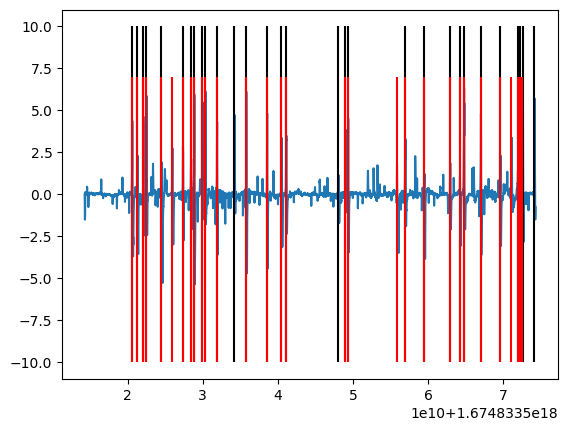

In [112]:
plt.plot(ts[0:12000], features[0:12000].mean(axis=1))

# [plt.vlines(blink_events[x].start_time, -10, 10, color="k") for x in range(0, len(blink_events))]

[plt.vlines(blink_events[x].start_time, -10, 10, color="k") for x in range(0, 30)]

[plt.vlines(blinks[blinks["label"]=="A"]["start_ts"].iloc[x], -10, 7, color="r") for x in range(0, 30)]


In [37]:
from src.blink_detector import get_params
of_params, pp_params = get_params()

all_samples = rec.all_samples

metrics_sample, metrics_ml, metrics_pp, n_samples = evaluate_clips(
            clip_names, all_samples, predictions, pp_params
        )

1674833520523197696

In [77]:

clip_name = ["2023-01-27_16-31-52-5f743ed0"]
metrics_sample, metrics_ml, metrics_pp, n_samples = evaluate_clips(clip_name, all_samples, predictions, pp_params)

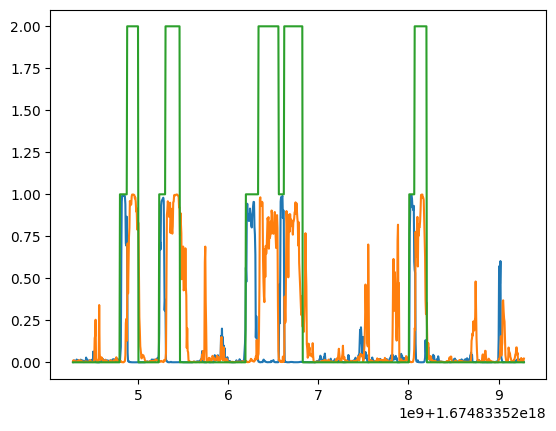

In [140]:
blinks = pd.read_json("/home/tom/experiments/neon_blink_detection/datasets/test_data/2023-01-27_16-31-52-5f743ed0/annotations.json").transpose()

plt.plot(ts[2000:3000], predictions[clip_name[0]][2000:3000, 1:3])
plt.plot(ts[2000:3000], s.labels[2000:3000])


In [106]:
ts, _, _ = rec._get_frames("2023-01-27_16-31-52-5f743ed0", convert_to_gray=True)

In [109]:
clip_name

['2023-01-27_16-31-52-5f743ed0']

(28065, 3)

In [117]:
ts.shape

(35972,)

In [118]:
clip_name

['2023-01-27_16-31-52-5f743ed0']

In [119]:
features.shape

(35972, 200)

In [128]:
s=all_samples[clip_name[0]]

In [138]:
sum(s.labels==2)

4130

In [218]:
a=Path("/home/tom/experiments/neon_blink_detection/datasets/test_data/2023-01-27_15-59-54-49a115d5")
b=next(a.glob("*.time"))
print(b)

/home/tom/experiments/neon_blink_detection/datasets/test_data/2023-01-27_15-59-54-49a115d5/Neon Scene Camera v1 ps1.time


In [27]:
# import video_loader
video_path = Path("/cluster/users/tom/experiments/neon_blink_detection/datasets/train_data")
of_path = Path("/cluster/users/tom/experiments/neon_blink_detection/datasets/train_data/optical_flow")

of_params = OfParams()
rec = video_loader(of_params)
# of_params = OfParams()
# rec.collect(clip_names, bg_ratio=3) 


In [28]:
ts, _, _ = rec._get_frames("2023-01-27_16-31-52-5f743ed0", convert_to_gray=True)

TypeError: 'bool' object is not iterable